##1. Data Cleaning

In [2]:
import re
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

# file paths
INPUT_PATH = "/content/drive/MyDrive/train_subtask1.csv"
OUTPUT_PATH = "/content/drive/MyDrive/train_subtask1_clean.csv"

# Set of vowels. Used to detect tokens with no vowels or long consonant runs
VOWELS = set("aeiouAEIOUàáâäæãåāÀÁÂÄÆÃÅĀèéêëēėęÈÉÊËĒĖĘìíîïīįÌÍÎÏĪĮòóôöõøōÒÓÔÖÕØŌùúûüūÙÚÛÜŪýÿÝŸœŒ")

# Apostrophes we treat as part of words (can't, I'm, haven't)
APOSTROPHES = {"'", "’"}

# Words we should never delete
WHITELIST = {
    "i","I","a","A","my","My","try","Try","TRY","why","Why","WHY","by","By","BY",
    "cry","Cry","CRY","dry","Dry","DRY","shy","Shy","SHY","fly","Fly","FLY","gym","Gym","GYM",
    "rhythm","Rhythm","sync","Sync","ppl","Ppl","pm","PM","TV","tv","Tv","PTSD","ptsd",
    "DM","dm","HD","hd","FB","fb","CD","cd","bc","BC","Bc","gf"
}

# Regex to match NA-like garbage tokens
NAN_PATTERNS = re.compile(r"^(?:na|Na|NA|n/a|N/a|N/A)$")


def split_token_edges(tok: str):
    # Return prefix, core word, and suffix punctuation
    if not tok:
        return "", "", ""

    start = 0
    end = len(tok)

    # Skip punctuation at the start
    while start < end and not tok[start].isalnum() and tok[start] not in APOSTROPHES:
        start += 1

    # Skip punctuation at the end
    while end > start and not tok[end-1].isalnum() and tok[end-1] not in APOSTROPHES:
        end -= 1

    return tok[:start], tok[start:end], tok[end:]


def is_nan_like(core: str) -> bool:
    # Check if token is NA-like garbage
    return bool(NAN_PATTERNS.match(core))


def longest_consonant_run(core: str) -> int:
    # Detect longest consecutive consonant segment
    max_run = 0
    cur = 0
    for ch in core:
        if ch.isalpha() and ch not in VOWELS:
            cur += 1
            max_run = max(max_run, cur)
        else:
            cur = 0
    return max_run


def should_delete_token(tok: str):
    # Decide whether a token should be removed
    if not tok:
        return False, None

    prefix, core, suffix = split_token_edges(tok)

    # If the token is only punctuation, keep it
    if core == "":
        return False, None

    # Never delete whitelisted tokens
    if tok in WHITELIST or core in WHITELIST or tok.lower() in WHITELIST:
        return False, None

    # Remove NA-like filler tokens
    if is_nan_like(core):
        return True, "nan_like"

    # Remove very long garbage tokens
    if len(core) > 20:
        return True, "len_20_plus"

    # Remove meaningless single consonants
    if len(core) == 1 and core.isalpha():
        if core not in VOWELS and core not in WHITELIST:
            return True, "single_consonant"
        return False, None

    # Detect gibberish made of many consonants
    if core.isalpha():
        run = longest_consonant_run(core)
        if len(core) >= 7 and run >= 6:
            return True, "gibberish_consonant_run"

    # Remove tokens with letters only but zero vowels
    if core.isalpha() and not any(ch in VOWELS for ch in core):
        if core not in WHITELIST:
            return True, "no_vowel"

    return False, None


def merge_apostrophe_contractions(text: str) -> str:
    # Convert word haven ' t to haven't
    return re.sub(r"(\w)\s*['’]\s*(\w)", r"\1'\2", text)


def clean_escaped_newlines(text: str) -> str:
    # Replace literal "\n" with a space
    return re.sub(r"\s*\\n\s*", " ", text)


def clean_text(text: str, stats: dict) -> str:
    # Skip NaN rows
    if pd.isna(text):
        return text

    s = str(text)

    # Normalize escaped newlines and apostrophe contractions
    s = clean_escaped_newlines(s)
    s = merge_apostrophe_contractions(s)

    tokens = s.split()
    cleaned = []

    for tok in tokens:
        delete, reason = should_delete_token(tok)
        if delete:
            stats["deleted_words"] += 1
            stats["reasons"][reason] = stats["reasons"].get(reason, 0) + 1
            continue

        cleaned.append(tok)

    return " ".join(cleaned)


def main():
    # Load dataset
    df = pd.read_csv(INPUT_PATH)

    # Ensure text column exists
    if "text" not in df.columns:
        raise ValueError("Column 'text' not found")

    stats = {"deleted_words": 0, "reasons": {}}

    # Clean each row
    df["text"] = df["text"].apply(lambda x: clean_text(x, stats))

    # Print only summary
    print("Total deleted words:", stats["deleted_words"])
    for reason, n in stats["reasons"].items():
        print(f"{reason}: {n}")

    # Save file
    df.to_csv(OUTPUT_PATH, index=False)
    print("Saved cleaned file:", OUTPUT_PATH)


if __name__ == "__main__":
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total deleted words: 498
len_20_plus: 58
single_consonant: 289
no_vowel: 66
nan_like: 47
gibberish_consonant_run: 38
Saved cleaned file: /content/drive/MyDrive/train_subtask1_clean.csv


##1.1 Check Clean versus Initial Data

In [4]:
import pandas as pd
import random

RAW_PATH = "/content/drive/MyDrive/train_subtask1.csv"
CLEAN_PATH = "/content/drive/MyDrive/train_subtask1_clean.csv"

# Labels to verify
LABEL_COLS = ["valence", "arousal"]

# Load data
raw = pd.read_csv(RAW_PATH)
clean = pd.read_csv(CLEAN_PATH)

# Random 50 sample comparison
print("\n=== RANDOM 50 ROWS: RAW vs CLEAN ===\n")

sample_idx = random.sample(range(len(raw)), 50)
for i in sample_idx:
    print(f"ROW {i}")
    print("RAW:  ", raw.loc[i, "text"])
    print("CLEAN:", clean.loc[i, "text"])
    print("-" * 80)

#Deleted token summary
print("\n=== DELETED TOKEN SUMMARY ===\n")

def tokenize(x):
    return str(x).split()

raw_tokens = raw["text"].apply(tokenize)
clean_tokens = clean["text"].apply(tokenize)

raw_count = sum(len(t) for t in raw_tokens)
clean_count = sum(len(t) for t in clean_tokens)

print("Raw token count:   ", raw_count)
print("Clean token count: ", clean_count)
print("Deleted tokens:    ", raw_count - clean_count)

#Verify labels unchanged
print("\n=== LABEL CONSISTENCY CHECK ===\n")

if all(col in raw.columns for col in LABEL_COLS):
    diff = (raw[LABEL_COLS] != clean[LABEL_COLS]).any().any()
    if diff:
        print("WARNING: Found label mismatches.")
        print(raw[LABEL_COLS].compare(clean[LABEL_COLS]))
    else:
        print("OK: Labels match exactly.")
else:
    print("Labels not found. Skipping label check.")


=== RANDOM 50 ROWS: RAW vs CLEAN ===

ROW 2345
RAW:   I am feeling extremely defeated .    I drive almost an hour away to sell my brand new clothing , hoping to make maybe like $50 .    They took one hoodie , a pair of sweats and a jacket and gave me seven dollars and sixty three cents .   That’s not even enough to cover the gas it took one way !   Ugh .   I am so broke .
CLEAN: I am feeling extremely defeated . I drive almost an hour away to sell my brand new clothing , hoping to make maybe like $50 . They took one hoodie , a pair of sweats and a jacket and gave me seven dollars and sixty three cents . That's not even enough to cover the gas it took one way ! Ugh . I am so broke .
--------------------------------------------------------------------------------
ROW 543
RAW:   Happy , Delightful , Calm , Contented , Reserved
CLEAN: Happy , Delightful , Calm , Contented , Reserved
--------------------------------------------------------------------------------
ROW 2715
RAW:   i ran my f

##1.3 Data EDA

User Coumt: 137
Rows: 2764
Columns: Index(['user_id', 'text_id', 'text', 'timestamp', 'collection_phase',
       'is_words', 'valence', 'arousal'],
      dtype='object')

Sample rows:
I've been feeling just fine . Nice and relaxed ...
I've been feeling pretty good . This is my last...
Still feeling sick today and sneezing alot with...
I'm still feeling kinda sickly but I powered th...
I'm feeling so much better today ! Seems like t...
I have been feeling somewhat down . I am trying...
The last day has been much better than yesterda...
        Tired , Exhausted , Calm , Content , Happy
          Content , Calm , Sleepy , Lazy , Relaxed
                  Content , Calm , Relaxed , Happy

Character length stats:
count    2764.000000
mean      155.311867
std       150.196126
min        18.000000
25%        43.000000
50%        56.000000
75%       240.000000
max      1065.000000
Name: text, dtype: float64

Token count stats:
count    2764.000000
mean       32.329233
std        30.288231
min

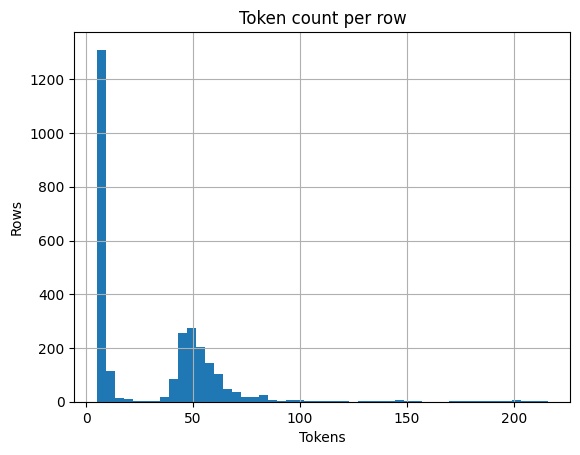

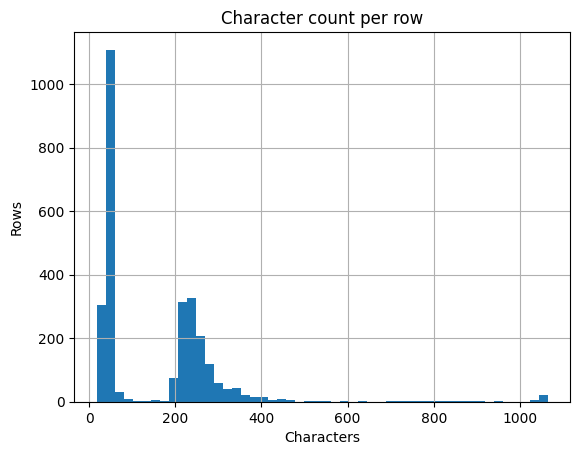


Valence statistics:
count    2764.000000
mean        0.216715
std         1.292142
min        -2.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: valence, dtype: float64

Arousal statistics:
count    2764.000000
mean        0.751085
std         0.753985
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: arousal, dtype: float64


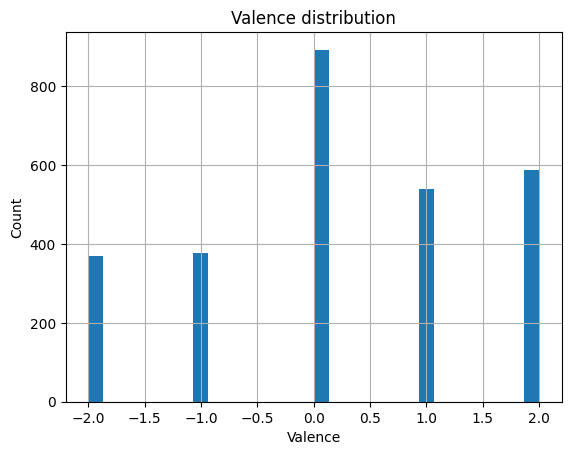

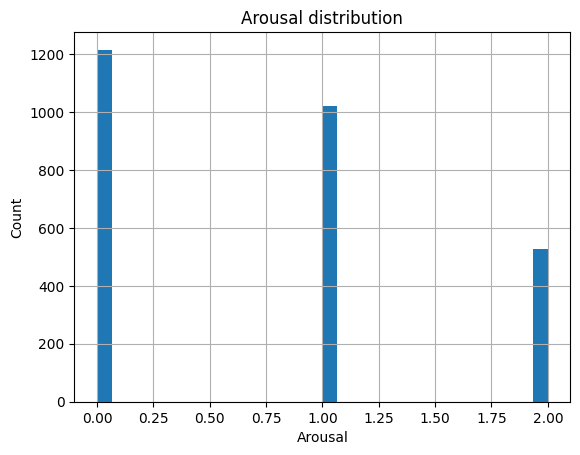

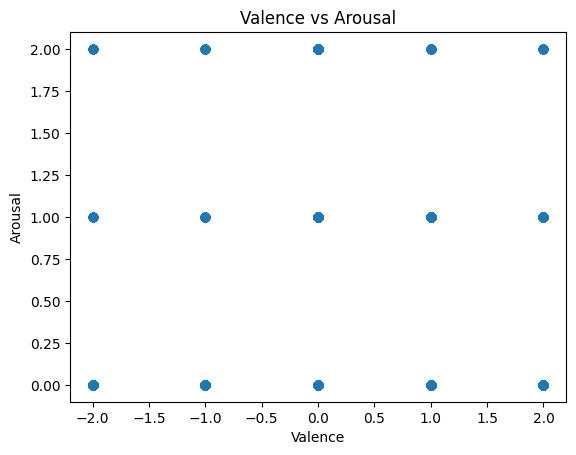

In [8]:
import re
import pandas as pd
import matplotlib.pyplot as plt

# Path to cleaned dataset
CLEAN_PATH = "/content/drive/MyDrive/train_subtask1_clean.csv"

def eda_clean_only():

    # Load cleaned data
    df = pd.read_csv(CLEAN_PATH)

    # Text column is fixed
    if "text" not in df.columns:
        raise ValueError("Column 'text' not found")

    print("User Coumt:", df['user_id'].nunique())
    print("Rows:", len(df))

    print("Columns:", df.columns)

    # Preview sample rows
    print("\nSample rows:")
    print(df["text"].head(10).to_string(index=False))

    # Character length per row
    char_len = df["text"].astype(str).str.len()
    print("\nCharacter length stats:")
    print(char_len.describe())

    # Token count per row
    tokens = df["text"].astype(str).str.split()
    token_len = tokens.str.len()

    print("\nToken count stats:")
    print(token_len.describe())

    # Build global token list
    all_tokens = [t.lower() for row in tokens for t in row]
    token_series = pd.Series(all_tokens)

    # Most frequent tokens
    top_words = token_series.value_counts().head(25)

    print("\nTop 25 most frequent words:")
    print(top_words)

    # Plot distribution of token counts
    plt.figure()
    token_len.hist(bins=50)
    plt.title("Token count per row")
    plt.xlabel("Tokens")
    plt.ylabel("Rows")
    plt.show()

    # Plot distribution of character counts
    plt.figure()
    char_len.hist(bins=50)
    plt.title("Character count per row")
    plt.xlabel("Characters")
    plt.ylabel("Rows")
    plt.show()

    if "valence" in df.columns and "arousal" in df.columns:

        print("\nValence statistics:")
        print(df["valence"].describe())

        print("\nArousal statistics:")
        print(df["arousal"].describe())

        # Valence distribution
        plt.figure()
        df["valence"].hist(bins=30)
        plt.title("Valence distribution")
        plt.xlabel("Valence")
        plt.ylabel("Count")
        plt.show()

        # Arousal distribution
        plt.figure()
        df["arousal"].hist(bins=30)
        plt.title("Arousal distribution")
        plt.xlabel("Arousal")
        plt.ylabel("Count")
        plt.show()

        # Joint distribution
        plt.figure()
        plt.scatter(df["valence"], df["arousal"], alpha=0.3)
        plt.xlabel("Valence")
        plt.ylabel("Arousal")
        plt.title("Valence vs Arousal")
        plt.show()

    else:
        print("\nValence/Arousal columns not found — skipping label EDA.")


if __name__ == "__main__":
    eda_clean_only()

##1.4 Data Splitting

In [11]:
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit

# Clean data path in drive
CLEAN_PATH = "/content/drive/MyDrive/train_subtask1_clean.csv"

# user id column
USER_COL = "user_id"

# Load cleaned dataset
df = pd.read_csv(CLEAN_PATH)

#Train 70% vs Rest 30%
gss1 = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=42)

train_idx, rest_idx = next(
    gss1.split(df, groups=df[USER_COL])
)

train = df.iloc[train_idx].copy()
rest = df.iloc[rest_idx].copy()

# Val vs Test from remaining 30% to %15 and %15
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=43)

val_idx, test_idx = next(
    gss2.split(rest, groups=rest[USER_COL])
)

val = rest.iloc[val_idx].copy()
test = rest.iloc[test_idx].copy()

# Stats
total = len(df)
print("Sizes:")
print("Train:", len(train))
print("Val:  ", len(val))
print("Test: ", len(test))

print("\nProportions:")
print("Train:", round(len(train) / total, 3))
print("Val:  ", round(len(val) / total, 3))
print("Test: ", round(len(test) / total, 3))

# Save splits in drive
train.to_csv("/content/drive/MyDrive/train_split.csv", index=False)
val.to_csv("/content/drive/MyDrive/val_split.csv", index=False)
test.to_csv("/content/drive/MyDrive/test_split.csv", index=False)

print("\nSaved splits.")

Sizes:
Train: 1914
Val:   530
Test:  320

Proportions:
Train: 0.692
Val:   0.192
Test:  0.116

Saved splits.


##2. Model setup: dataset + tokenizer + dataloaders + backbone

In [12]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel

# Paths for splits
TRAIN_PATH = "/content/drive/MyDrive/train_split.csv"
VAL_PATH   = "/content/drive/MyDrive/val_split.csv"
TEST_PATH  = "/content/drive/MyDrive/test_split.csv"

# Fixed column names
TEXT_COL    = "text"
VALENCE_COL = "valence"
AROUSAL_COL = "arousal"


class VARegressionDataset(Dataset):
    #Dataset for valence–arousal regression.

    def __init__(self, csv_path, tokenizer, max_len: int = 128):
        # Read split file
        self.df = pd.read_csv(csv_path)

        # Sanity checks for required columns
        for col in [TEXT_COL, VALENCE_COL, AROUSAL_COL]:
            if col not in self.df.columns:
                raise ValueError(f"Column '{col}' not found in {csv_path}")

        # Cache columns in lists
        self.texts    = self.df[TEXT_COL].astype(str).tolist()
        self.valences = self.df[VALENCE_COL].astype(float).tolist()
        self.arousals = self.df[AROUSAL_COL].astype(float).tolist()

        self.tokenizer = tokenizer
        self.max_len   = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Get raw fields
        text    = self.texts[idx]
        valence = self.valences[idx]
        arousal = self.arousals[idx]

        # Tokenize text
        enc = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt",
        )

        # Target vector [valence, arousal]
        labels = torch.tensor([valence, arousal], dtype=torch.float)

        item = {
            "input_ids":      enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels":         labels,
        }

        # Add token_type_ids if model uses them
        if "token_type_ids" in enc:
            item["token_type_ids"] = enc["token_type_ids"].squeeze(0)

        return item


def create_va_dataloaders(
    tokenizer,
    max_len: int = 128,
    batch_size: int = 16,
    num_workers: int = 2,
):
    #Create train/val/test dataloaders for VA regression

    train_dataset = VARegressionDataset(TRAIN_PATH, tokenizer, max_len)
    val_dataset   = VARegressionDataset(VAL_PATH,   tokenizer, max_len)
    test_dataset  = VARegressionDataset(TEST_PATH,  tokenizer, max_len)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    return train_loader, val_loader, test_loader


class VARegressor(nn.Module):

    #Transformer backbone + small regression head


    def __init__(self, model_name: str):
        super().__init__()

        #Load transformer
        self.backbone = AutoModel.from_pretrained(model_name)
        hidden_size = self.backbone.config.hidden_size

        # Simple linear head hidden -> 2
        self.reg_head = nn.Linear(hidden_size, 2)

        # MSE for regression loss
        self.mse = nn.MSELoss()

    def forward(self, input_ids, attention_mask, token_type_ids=None, labels=None):
        # Run backbone
        outputs = self.backbone(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )

        # Get sentence representation
        # If pooler_output exists, use it otherwise use CLS token embedding
        if hasattr(outputs, "pooler_output") and outputs.pooler_output is not None:
            pooled = outputs.pooler_output              # [batch, hidden]
        else:
            pooled = outputs.last_hidden_state[:, 0, :] # [batch, hidden]

        # Map to 2D regression outputs
        preds = self.reg_head(pooled)                   # [batch, 2]

        # Compute loss only during training.
        # If labels are not provided (inference), we skip loss calculation
        loss = None
        if labels is not None:
            # labels[:, 0] -> valence, labels[:, 1] -> arousal
            loss_v = self.mse(preds[:, 0], labels[:, 0])
            loss_a = self.mse(preds[:, 1], labels[:, 1])
            loss = loss_v + loss_a

        return {"loss": loss, "preds": preds}

#Build tokenizer, dataloaders and model for a given backbone.
def build_pipeline(
    model_name: str = "bert-base-uncased",
    max_len: int = 128,
    batch_size: int = 16,
    num_workers: int = 2,
):


    # Load tokenizer for chosen backbone
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Create dataloaders
    train_loader, val_loader, test_loader = create_va_dataloaders(
        tokenizer,
        max_len=max_len,
        batch_size=batch_size,
        num_workers=num_workers,
    )

    # Create model and move to device
    model = VARegressor(model_name)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    return tokenizer, train_loader, val_loader, test_loader, model, device



##2.1 train / eval / run_experiment

In [13]:
import torch
import torch.nn as nn
from torch.optim import AdamW

def mse_loss(preds, targets):
    # MSE per dim -> [valence_MSE, arousal_MSE]
    return ((preds - targets) ** 2).mean(dim=0)


def mae_loss(preds, targets):
    # MAE per dim -> [valence_MAE, arousal_MAE]
    return (preds - targets).abs().mean(dim=0)


def pearsonr_torch(x, y):
    # Pearson correlation between two value vectors
    x = x - x.mean()
    y = y - y.mean()

    num = (x * y).sum()
    denom = torch.sqrt((x**2).sum()) * torch.sqrt((y**2).sum()) + 1e-8
    return num / denom


# Train / eval loops

def train_one_epoch(model, dataloader, optimizer, device):
    # One training epoch over a dataloader
    model.train()
    total_loss = 0.0
    n_batches = 0

    for batch in dataloader:
        # Move batch to device
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)

        token_type_ids = batch.get("token_type_ids")
        if token_type_ids is not None:
            token_type_ids = token_type_ids.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            labels=labels,
        )
        loss = outputs["loss"]

        # Backward + update
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        n_batches  += 1

    return total_loss / max(n_batches, 1)


def evaluate(model, dataloader, device):
    # Compute MSE, MAE, Pearson on a dataloader
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids      = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels         = batch["labels"].to(device)

            token_type_ids = batch.get("token_type_ids")
            if token_type_ids is not None:
                token_type_ids = token_type_ids.to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
                labels=None,          # no loss in eval
            )
            preds = outputs["preds"]  # [batch, 2]

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    # Stack all batches into one tensor
    all_preds  = torch.cat(all_preds, dim=0)   # [N, 2]
    all_labels = torch.cat(all_labels, dim=0)  # [N, 2]

    # MSE / MAE per dim
    mse = mse_loss(all_preds, all_labels)      # [2]
    mae = mae_loss(all_preds, all_labels)      # [2]

    # Pearson per dim
    p_val = pearsonr_torch(all_preds[:, 0], all_labels[:, 0]).item()
    p_aro = pearsonr_torch(all_preds[:, 1], all_labels[:, 1]).item()

    metrics = {
        "mse_valence":  mse[0].item(),
        "mse_arousal":  mse[1].item(),
        "mse_total":    mse.mean().item(),
        "mae_valence":  mae[0].item(),
        "mae_arousal":  mae[1].item(),
        "mae_total":    mae.mean().item(),
        "pearson_val":  p_val,
        "pearson_aro":  p_aro,
        "pearson_mean": (p_val + p_aro) / 2.0,
    }
    return metrics


def run_experiment(
    model_name: str,
    lr: float = 2e-5,
    batch_size: int = 16,
    max_len: int = 128,
    epochs: int = 3,
    weight_decay: float = 0.01,
    num_workers: int = 2,
):
    # Train + validate for one config. Return best epoch and validation metrics.
    print(f"\n=== Running experiment: model={model_name}, lr={lr} ===")

    # Build pipeline for this model
    tokenizer, train_loader, val_loader, test_loader, model, device = build_pipeline(
        model_name=model_name,
        max_len=max_len,
        batch_size=batch_size,
        num_workers=num_workers,
    )

    # Optimizer
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_metrics = None
    best_epoch = -1
    history = []

    for epoch in range(1, epochs + 1):
        print(f"\n----- EPOCH {epoch}/{epochs} -----")

        train_loss = train_one_epoch(model, train_loader, optimizer, device)
        val_metrics = evaluate(model, val_loader, device)

        # Log training loss into metrics for convenience
        val_metrics["train_loss"] = train_loss

        # Track best by lowest total MSE
        if best_metrics is None or val_metrics["mse_total"] < best_metrics["mse_total"]:
            best_metrics = val_metrics
            best_epoch = epoch

        history.append((epoch, val_metrics))

        # Print epoch summary
        print(f"Train loss: {train_loss:.4f}")
        print(
            "Val MSE (valence/arousal/mean): "
            f"{val_metrics['mse_valence']:.4f} / "
            f"{val_metrics['mse_arousal']:.4f} / "
            f"{val_metrics['mse_total']:.4f}"
        )
        print(
            "Val MAE (valence/arousal/mean): "
            f"{val_metrics['mae_valence']:.4f} / "
            f"{val_metrics['mae_arousal']:.4f} / "
            f"{val_metrics['mae_total']:.4f}"
        )
        print(
            "Val Pearson (valence/arousal/mean): "
            f"{val_metrics['pearson_val']:.4f} / "
            f"{val_metrics['pearson_aro']:.4f} / "
            f"{val_metrics['pearson_mean']:.4f}"
        )

    result = {
        "model_name":   model_name,
        "lr":           lr,
        "batch_size":   batch_size,
        "weight_decay": weight_decay,
        "best_epoch":   best_epoch,
        "best_metrics": best_metrics,
        "history":      history,
    }
    return result

##2.2 Hyperparameter Search

In [15]:
model_candidates = [
    "bert-base-uncased",
    "microsoft/deberta-v3-base",
]

lr_candidates = [1e-5, 2e-5, 3e-5]
batch_candidates = [16, 32]
weight_decay_candidates = [0.0, 0.01]

all_results = []

for m_name in model_candidates:
    for lr in lr_candidates:
        for batch_size in batch_candidates:
            for wd in weight_decay_candidates:
                print(
                    f"\n>>> Running: model={m_name}, lr={lr:.1e}, "
                    f"batch={batch_size}, weight_decay={wd}"
                )

                res = run_experiment(
                    model_name=m_name,
                    lr=lr,
                    batch_size=batch_size,
                    max_len=128,
                    epochs=3,
                    weight_decay=wd,
                    num_workers=2,
                )
                all_results.append(res)

# Sort by best total MSE
all_results = sorted(
    all_results, key=lambda x: x["best_metrics"]["mse_total"]
)

print("\n===== HYPERPARAM SUMMARY (sorted by total MSE) =====")
for r in all_results:
    bm = r["best_metrics"]
    print(
        f"Model={r['model_name']}, "
        f"lr={r['lr']:.1e}, "
        f"batch={r['batch_size']}, "
        f"weight_decay={r['weight_decay']}, "
        f"best_epoch={r['best_epoch']}, "
        f"MSE_total={bm['mse_total']:.4f}, "
        f"MAE_total={bm['mae_total']:.4f}, "
        f"Pearson_mean={bm['pearson_mean']:.4f}"
    )


>>> Running: model=bert-base-uncased, lr=1.0e-05, batch=16, weight_decay=0.0

=== Running experiment: model=bert-base-uncased, lr=1e-05 ===

----- EPOCH 1/3 -----
Train loss: 1.7118
Val MSE (valence/arousal/mean): 1.0074 / 0.4530 / 0.7302
Val MAE (valence/arousal/mean): 0.8338 / 0.5557 / 0.6948
Val Pearson (valence/arousal/mean): 0.6901 / 0.3346 / 0.5124

----- EPOCH 2/3 -----
Train loss: 1.1824
Val MSE (valence/arousal/mean): 1.0407 / 0.4455 / 0.7431
Val MAE (valence/arousal/mean): 0.8310 / 0.5419 / 0.6864
Val Pearson (valence/arousal/mean): 0.6802 / 0.3659 / 0.5230

----- EPOCH 3/3 -----
Train loss: 0.9852
Val MSE (valence/arousal/mean): 1.0497 / 0.4380 / 0.7439
Val MAE (valence/arousal/mean): 0.8426 / 0.5546 / 0.6986
Val Pearson (valence/arousal/mean): 0.6824 / 0.4230 / 0.5527

>>> Running: model=bert-base-uncased, lr=1.0e-05, batch=16, weight_decay=0.01

=== Running experiment: model=bert-base-uncased, lr=1e-05 ===

----- EPOCH 1/3 -----
Train loss: 1.8197
Val MSE (valence/arousal

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(



----- EPOCH 1/3 -----
Train loss: 1.8711
Val MSE (valence/arousal/mean): 1.0249 / 0.4860 / 0.7554
Val MAE (valence/arousal/mean): 0.8181 / 0.5907 / 0.7044
Val Pearson (valence/arousal/mean): 0.6834 / 0.2077 / 0.4455

----- EPOCH 2/3 -----
Train loss: 1.3224
Val MSE (valence/arousal/mean): 1.0558 / 0.4776 / 0.7667
Val MAE (valence/arousal/mean): 0.8427 / 0.5660 / 0.7044
Val Pearson (valence/arousal/mean): 0.7018 / 0.2726 / 0.4872

----- EPOCH 3/3 -----
Train loss: 1.1125
Val MSE (valence/arousal/mean): 1.0814 / 0.5128 / 0.7971
Val MAE (valence/arousal/mean): 0.8314 / 0.5668 / 0.6991
Val Pearson (valence/arousal/mean): 0.6916 / 0.2979 / 0.4948

>>> Running: model=microsoft/deberta-v3-base, lr=1.0e-05, batch=16, weight_decay=0.01

=== Running experiment: model=microsoft/deberta-v3-base, lr=1e-05 ===


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(



----- EPOCH 1/3 -----
Train loss: 1.8708
Val MSE (valence/arousal/mean): 1.0540 / 0.4976 / 0.7758
Val MAE (valence/arousal/mean): 0.8455 / 0.6058 / 0.7257
Val Pearson (valence/arousal/mean): 0.6734 / 0.0447 / 0.3591

----- EPOCH 2/3 -----
Train loss: 1.3726
Val MSE (valence/arousal/mean): 1.0259 / 0.4782 / 0.7520
Val MAE (valence/arousal/mean): 0.8331 / 0.5713 / 0.7022
Val Pearson (valence/arousal/mean): 0.6924 / 0.2858 / 0.4891

----- EPOCH 3/3 -----
Train loss: 1.1579
Val MSE (valence/arousal/mean): 1.2547 / 0.5237 / 0.8892
Val MAE (valence/arousal/mean): 0.9145 / 0.5908 / 0.7526
Val Pearson (valence/arousal/mean): 0.6651 / 0.2731 / 0.4691

>>> Running: model=microsoft/deberta-v3-base, lr=1.0e-05, batch=32, weight_decay=0.0

=== Running experiment: model=microsoft/deberta-v3-base, lr=1e-05 ===


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(



----- EPOCH 1/3 -----
Train loss: 2.4272
Val MSE (valence/arousal/mean): 1.4246 / 0.4720 / 0.9483
Val MAE (valence/arousal/mean): 0.9954 / 0.5981 / 0.7968
Val Pearson (valence/arousal/mean): 0.5429 / 0.2480 / 0.3955

----- EPOCH 2/3 -----
Train loss: 1.6163
Val MSE (valence/arousal/mean): 1.0117 / 0.4456 / 0.7287
Val MAE (valence/arousal/mean): 0.8454 / 0.5758 / 0.7106
Val Pearson (valence/arousal/mean): 0.6793 / 0.2728 / 0.4760

----- EPOCH 3/3 -----
Train loss: 1.2788
Val MSE (valence/arousal/mean): 1.0788 / 0.5172 / 0.7980
Val MAE (valence/arousal/mean): 0.8482 / 0.6005 / 0.7243
Val Pearson (valence/arousal/mean): 0.6858 / 0.3433 / 0.5146

>>> Running: model=microsoft/deberta-v3-base, lr=1.0e-05, batch=32, weight_decay=0.01

=== Running experiment: model=microsoft/deberta-v3-base, lr=1e-05 ===


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(



----- EPOCH 1/3 -----
Train loss: 2.1199
Val MSE (valence/arousal/mean): 1.3049 / 0.5325 / 0.9187
Val MAE (valence/arousal/mean): 0.9387 / 0.6177 / 0.7782
Val Pearson (valence/arousal/mean): 0.5761 / -0.0683 / 0.2539

----- EPOCH 2/3 -----
Train loss: 1.4932
Val MSE (valence/arousal/mean): 1.0951 / 0.4922 / 0.7937
Val MAE (valence/arousal/mean): 0.8641 / 0.5938 / 0.7290
Val Pearson (valence/arousal/mean): 0.6890 / 0.1341 / 0.4116

----- EPOCH 3/3 -----
Train loss: 1.2574
Val MSE (valence/arousal/mean): 1.0033 / 0.4505 / 0.7269
Val MAE (valence/arousal/mean): 0.8361 / 0.5560 / 0.6961
Val Pearson (valence/arousal/mean): 0.7006 / 0.3265 / 0.5136

>>> Running: model=microsoft/deberta-v3-base, lr=2.0e-05, batch=16, weight_decay=0.0

=== Running experiment: model=microsoft/deberta-v3-base, lr=2e-05 ===


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(



----- EPOCH 1/3 -----
Train loss: 1.9159
Val MSE (valence/arousal/mean): 1.1065 / 0.4494 / 0.7780
Val MAE (valence/arousal/mean): 0.8809 / 0.5782 / 0.7295
Val Pearson (valence/arousal/mean): 0.6888 / 0.2564 / 0.4726

----- EPOCH 2/3 -----
Train loss: 1.2473
Val MSE (valence/arousal/mean): 1.1104 / 0.4758 / 0.7931
Val MAE (valence/arousal/mean): 0.8655 / 0.5578 / 0.7116
Val Pearson (valence/arousal/mean): 0.6892 / 0.2751 / 0.4822

----- EPOCH 3/3 -----
Train loss: 1.0332
Val MSE (valence/arousal/mean): 1.0624 / 0.4707 / 0.7666
Val MAE (valence/arousal/mean): 0.8474 / 0.5495 / 0.6985
Val Pearson (valence/arousal/mean): 0.6810 / 0.3564 / 0.5187

>>> Running: model=microsoft/deberta-v3-base, lr=2.0e-05, batch=16, weight_decay=0.01

=== Running experiment: model=microsoft/deberta-v3-base, lr=2e-05 ===


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(



----- EPOCH 1/3 -----
Train loss: 1.7860
Val MSE (valence/arousal/mean): 1.0675 / 0.4679 / 0.7677
Val MAE (valence/arousal/mean): 0.8484 / 0.5775 / 0.7129
Val Pearson (valence/arousal/mean): 0.6574 / 0.2789 / 0.4682

----- EPOCH 2/3 -----
Train loss: 1.2636
Val MSE (valence/arousal/mean): 1.1624 / 0.4928 / 0.8276
Val MAE (valence/arousal/mean): 0.8755 / 0.5632 / 0.7194
Val Pearson (valence/arousal/mean): 0.6644 / 0.3105 / 0.4875

----- EPOCH 3/3 -----
Train loss: 1.0648
Val MSE (valence/arousal/mean): 1.0119 / 0.4456 / 0.7287
Val MAE (valence/arousal/mean): 0.8180 / 0.5381 / 0.6780
Val Pearson (valence/arousal/mean): 0.6840 / 0.3660 / 0.5250

>>> Running: model=microsoft/deberta-v3-base, lr=2.0e-05, batch=32, weight_decay=0.0

=== Running experiment: model=microsoft/deberta-v3-base, lr=2e-05 ===


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(



----- EPOCH 1/3 -----
Train loss: 1.8167
Val MSE (valence/arousal/mean): 1.0831 / 0.4307 / 0.7569
Val MAE (valence/arousal/mean): 0.8648 / 0.5564 / 0.7106
Val Pearson (valence/arousal/mean): 0.7029 / 0.2786 / 0.4908

----- EPOCH 2/3 -----
Train loss: 1.2631
Val MSE (valence/arousal/mean): 0.9708 / 0.4755 / 0.7231
Val MAE (valence/arousal/mean): 0.8091 / 0.5628 / 0.6860
Val Pearson (valence/arousal/mean): 0.6943 / 0.3375 / 0.5159

----- EPOCH 3/3 -----
Train loss: 1.0975
Val MSE (valence/arousal/mean): 1.1626 / 0.4601 / 0.8113
Val MAE (valence/arousal/mean): 0.8769 / 0.5415 / 0.7092
Val Pearson (valence/arousal/mean): 0.6766 / 0.3862 / 0.5314

>>> Running: model=microsoft/deberta-v3-base, lr=2.0e-05, batch=32, weight_decay=0.01

=== Running experiment: model=microsoft/deberta-v3-base, lr=2e-05 ===


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(



----- EPOCH 1/3 -----
Train loss: 2.0927
Val MSE (valence/arousal/mean): 1.0747 / 0.5012 / 0.7880
Val MAE (valence/arousal/mean): 0.8651 / 0.6015 / 0.7333
Val Pearson (valence/arousal/mean): 0.6694 / 0.0945 / 0.3820

----- EPOCH 2/3 -----
Train loss: 1.3552
Val MSE (valence/arousal/mean): 1.0330 / 0.4428 / 0.7379
Val MAE (valence/arousal/mean): 0.8334 / 0.5370 / 0.6852
Val Pearson (valence/arousal/mean): 0.6928 / 0.3530 / 0.5229

----- EPOCH 3/3 -----
Train loss: 1.1151
Val MSE (valence/arousal/mean): 1.1537 / 0.4554 / 0.8045
Val MAE (valence/arousal/mean): 0.8917 / 0.5519 / 0.7218
Val Pearson (valence/arousal/mean): 0.6668 / 0.3753 / 0.5211

>>> Running: model=microsoft/deberta-v3-base, lr=3.0e-05, batch=16, weight_decay=0.0

=== Running experiment: model=microsoft/deberta-v3-base, lr=3e-05 ===


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(



----- EPOCH 1/3 -----
Train loss: 1.6655
Val MSE (valence/arousal/mean): 0.9912 / 0.5611 / 0.7762
Val MAE (valence/arousal/mean): 0.8279 / 0.6236 / 0.7257
Val Pearson (valence/arousal/mean): 0.6976 / 0.2113 / 0.4545

----- EPOCH 2/3 -----
Train loss: 1.1772
Val MSE (valence/arousal/mean): 1.0641 / 0.4973 / 0.7807
Val MAE (valence/arousal/mean): 0.8304 / 0.5649 / 0.6976
Val Pearson (valence/arousal/mean): 0.6772 / 0.2812 / 0.4792

----- EPOCH 3/3 -----
Train loss: 0.9649
Val MSE (valence/arousal/mean): 1.1010 / 0.4813 / 0.7912
Val MAE (valence/arousal/mean): 0.8525 / 0.5698 / 0.7111
Val Pearson (valence/arousal/mean): 0.6865 / 0.4046 / 0.5455

>>> Running: model=microsoft/deberta-v3-base, lr=3.0e-05, batch=16, weight_decay=0.01

=== Running experiment: model=microsoft/deberta-v3-base, lr=3e-05 ===


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(



----- EPOCH 1/3 -----
Train loss: 1.9403
Val MSE (valence/arousal/mean): 1.0179 / 0.5202 / 0.7691
Val MAE (valence/arousal/mean): 0.8446 / 0.6146 / 0.7296
Val Pearson (valence/arousal/mean): 0.6802 / 0.1198 / 0.4000

----- EPOCH 2/3 -----
Train loss: 1.3708
Val MSE (valence/arousal/mean): 1.1213 / 0.4197 / 0.7705
Val MAE (valence/arousal/mean): 0.8699 / 0.5309 / 0.7004
Val Pearson (valence/arousal/mean): 0.6556 / 0.3447 / 0.5002

----- EPOCH 3/3 -----
Train loss: 1.0686
Val MSE (valence/arousal/mean): 1.0929 / 0.4464 / 0.7696
Val MAE (valence/arousal/mean): 0.8461 / 0.5350 / 0.6905
Val Pearson (valence/arousal/mean): 0.6728 / 0.3519 / 0.5124

>>> Running: model=microsoft/deberta-v3-base, lr=3.0e-05, batch=32, weight_decay=0.0

=== Running experiment: model=microsoft/deberta-v3-base, lr=3e-05 ===


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(



----- EPOCH 1/3 -----
Train loss: 1.9507
Val MSE (valence/arousal/mean): 1.1527 / 0.4786 / 0.8157
Val MAE (valence/arousal/mean): 0.8987 / 0.5935 / 0.7461
Val Pearson (valence/arousal/mean): 0.6656 / 0.1134 / 0.3895

----- EPOCH 2/3 -----
Train loss: 1.3959
Val MSE (valence/arousal/mean): 1.0620 / 0.4635 / 0.7628
Val MAE (valence/arousal/mean): 0.8468 / 0.5514 / 0.6991
Val Pearson (valence/arousal/mean): 0.6769 / 0.2950 / 0.4859

----- EPOCH 3/3 -----
Train loss: 1.1513
Val MSE (valence/arousal/mean): 1.0458 / 0.4504 / 0.7481
Val MAE (valence/arousal/mean): 0.8434 / 0.5406 / 0.6920
Val Pearson (valence/arousal/mean): 0.6685 / 0.3534 / 0.5110

>>> Running: model=microsoft/deberta-v3-base, lr=3.0e-05, batch=32, weight_decay=0.01

=== Running experiment: model=microsoft/deberta-v3-base, lr=3e-05 ===


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(



----- EPOCH 1/3 -----
Train loss: 1.7570
Val MSE (valence/arousal/mean): 1.0644 / 0.4722 / 0.7683
Val MAE (valence/arousal/mean): 0.8526 / 0.5633 / 0.7079
Val Pearson (valence/arousal/mean): 0.6821 / 0.3258 / 0.5039

----- EPOCH 2/3 -----
Train loss: 1.2001
Val MSE (valence/arousal/mean): 1.2006 / 0.5288 / 0.8647
Val MAE (valence/arousal/mean): 0.8796 / 0.5717 / 0.7256
Val Pearson (valence/arousal/mean): 0.6274 / 0.2875 / 0.4574

----- EPOCH 3/3 -----
Train loss: 1.0300
Val MSE (valence/arousal/mean): 1.3450 / 0.4654 / 0.9052
Val MAE (valence/arousal/mean): 0.9205 / 0.5298 / 0.7252
Val Pearson (valence/arousal/mean): 0.6310 / 0.3716 / 0.5013

===== HYPERPARAM SUMMARY (sorted by total MSE) =====
Model=bert-base-uncased, lr=1.0e-05, batch=32, weight_decay=0.01, best_epoch=2, MSE_total=0.7010, MAE_total=0.6834, Pearson_mean=0.5402
Model=bert-base-uncased, lr=3.0e-05, batch=16, weight_decay=0.0, best_epoch=1, MSE_total=0.7064, MAE_total=0.6713, Pearson_mean=0.5213
Model=bert-base-uncased,

##3. Full Training

In [16]:
import torch
from torch.optim import AdamW


# Final training with best hyperparams
BEST_MODEL_NAME   = "bert-base-uncased"
BEST_LR           = 2e-5
BEST_BATCH_SIZE   = 16
BEST_MAX_LEN      = 128
BEST_WEIGHT_DECAY = 0.0
BEST_NUM_WORKERS  = 2
EPOCHS            = 10

# Build data + model for best config
tokenizer, train_loader, val_loader, test_loader, model, device = build_pipeline(
    model_name=BEST_MODEL_NAME,
    max_len=BEST_MAX_LEN,
    batch_size=BEST_BATCH_SIZE,
    num_workers=BEST_NUM_WORKERS,
)

# Optimizer
optimizer = AdamW(
    model.parameters(),
    lr=BEST_LR,
    weight_decay=BEST_WEIGHT_DECAY,
)

best_val_mse   = float("inf")
best_state_dict = None
best_epoch      = -1
history = []

for epoch in range(1, EPOCHS + 1):
    print(f"\n===== FINAL TRAINING | EPOCH {epoch}/{EPOCHS} =====")

    # Train on train split
    train_loss = train_one_epoch(model, train_loader, optimizer, device)

    # Evaluate on val split
    val_metrics = evaluate(model, val_loader, device)
    current_val_mse = val_metrics["mse_total"]

    # Log for later (plot, report)
    val_metrics["train_loss"] = train_loss
    history.append((epoch, val_metrics))

    #Track best epoch by lowest total MSE
    if current_val_mse < best_val_mse:
        best_val_mse = current_val_mse
        best_epoch   = epoch
        best_state_dict = model.state_dict()  # save a copy of weights

    #Print epoch summary
    print(f"Train loss: {train_loss:.4f}")
    print(
        "Val MSE (valence/arousal/mean): "
        f"{val_metrics['mse_valence']:.4f} / "
        f"{val_metrics['mse_arousal']:.4f} / "
        f"{val_metrics['mse_total']:.4f}"
    )
    print(
        "Val MAE (valence/arousal/mean): "
        f"{val_metrics['mae_valence']:.4f} / "
        f"{val_metrics['mae_arousal']:.4f} / "
        f"{val_metrics['mae_total']:.4f}"
    )
    print(
        "Val Pearson (valence/arousal/mean): "
        f"{val_metrics['pearson_val']:.4f} / "
        f"{val_metrics['pearson_aro']:.4f} / "
        f"{val_metrics['pearson_mean']:.4f}"
    )


# Load best epoch and evaluate on test
if best_state_dict is not None:
    model.load_state_dict(best_state_dict)
    print(
        f"\nLoaded best model from epoch {best_epoch} "
        f"(val total MSE = {best_val_mse:.4f}) for test evaluation."
    )
else:
    print("\nWARNING: best_state_dict is None, using last epoch model for test.")

# Final test evaluation
test_metrics = evaluate(model, test_loader, device)

print("\n===== FINAL TEST RESULTS (best config) =====")
print(
    "Test MSE (valence/arousal/mean): "
    f"{test_metrics['mse_valence']:.4f} / "
    f"{test_metrics['mse_arousal']:.4f} / "
    f"{test_metrics['mse_total']:.4f}"
)
print(
    "Test MAE (valence/arousal/mean): "
    f"{test_metrics['mae_valence']:.4f} / "
    f"{test_metrics['mae_arousal']:.4f} / "
    f"{test_metrics['mae_total']:.4f}"
)
print(
    "Test Pearson (valence/arousal/mean): "
    f"{test_metrics['pearson_val']:.4f} / "
    f"{test_metrics['pearson_aro']:.4f} / "
    f"{test_metrics['pearson_mean']:.4f}"
)


===== FINAL TRAINING | EPOCH 1/10 =====
Train loss: 1.5877
Val MSE (valence/arousal/mean): 0.9713 / 0.4920 / 0.7317
Val MAE (valence/arousal/mean): 0.8077 / 0.5767 / 0.6922
Val Pearson (valence/arousal/mean): 0.6959 / 0.2679 / 0.4819

===== FINAL TRAINING | EPOCH 2/10 =====
Train loss: 1.1517
Val MSE (valence/arousal/mean): 1.1281 / 0.4496 / 0.7889
Val MAE (valence/arousal/mean): 0.8726 / 0.5418 / 0.7072
Val Pearson (valence/arousal/mean): 0.6755 / 0.3606 / 0.5181

===== FINAL TRAINING | EPOCH 3/10 =====
Train loss: 0.9351
Val MSE (valence/arousal/mean): 1.0519 / 0.4481 / 0.7500
Val MAE (valence/arousal/mean): 0.8355 / 0.5313 / 0.6834
Val Pearson (valence/arousal/mean): 0.6835 / 0.3685 / 0.5260

===== FINAL TRAINING | EPOCH 4/10 =====
Train loss: 0.7105
Val MSE (valence/arousal/mean): 1.0872 / 0.4472 / 0.7672
Val MAE (valence/arousal/mean): 0.8453 / 0.5210 / 0.6832
Val Pearson (valence/arousal/mean): 0.6591 / 0.4326 / 0.5459

===== FINAL TRAINING | EPOCH 5/10 =====
Train loss: 0.5703


##4. Evaluation

,epoch,train_loss,val_mse,val_mae,val_pearson,val_mse_valence,val_mse_arousal
0,1,1.587691,0.731677,0.692185,0.481888,0.971317,0.492037
1,2,1.151749,0.788892,0.707225,0.518052,1.128145,0.449640
2,3,0.935072,0.749999,0.683370,0.526006,1.051852,0.448146
3,4,0.710496,0.767226,0.683170,0.545863,1.087240,0.447211
4,5,0.570343,0.805974,0.682824,0.539834,1.151950,0.459999
5,6,0.447798,0.872245,0.727799,0.512567,1.182310,0.562180
6,7,0.361422,0.809167,0.707075,0.521553,1.115748,0.502586
7,8,0.295006,0.901432,0.736606,0.505155,1.261240,0.541624
8,9,0.256303,0.857150,0.717439,0.494894,1.204384,0.509915
9,10,0.211227,0.861804,0.711190,0.517819,1.225741,0.497867


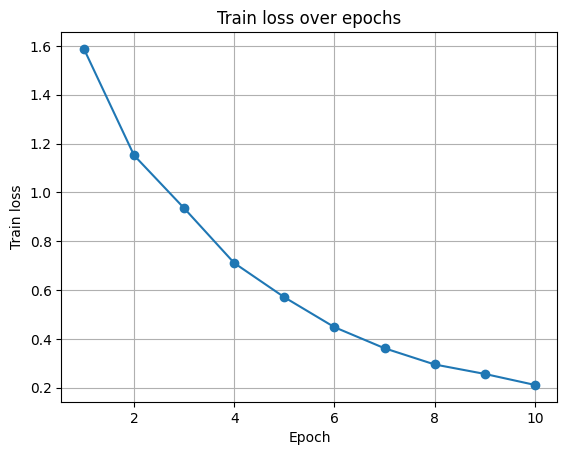

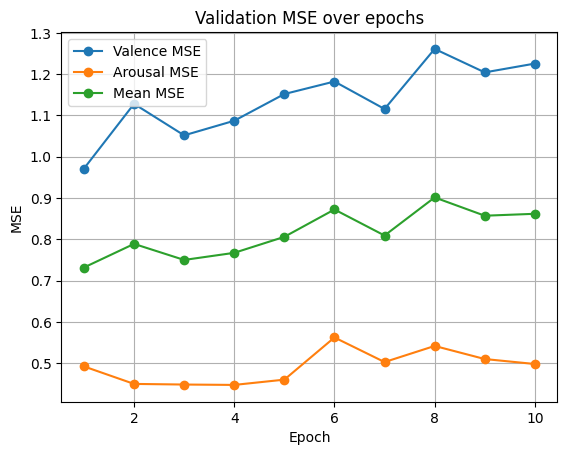

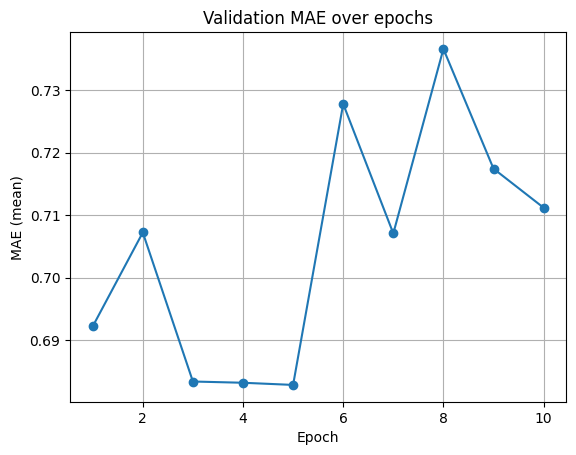

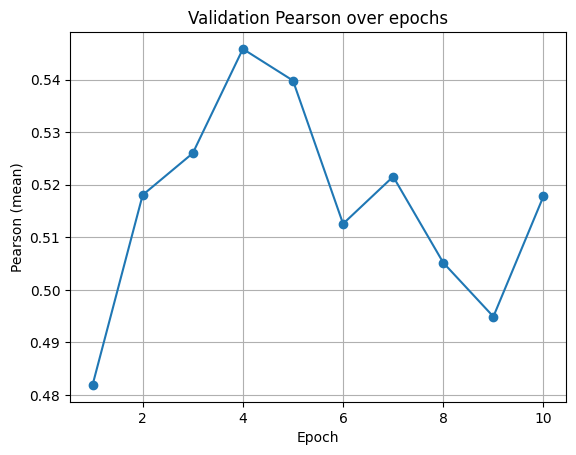

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Build a dataframe from training history
history_rows = []
for epoch, m in history:
    history_rows.append({
        "epoch": epoch,
        "train_loss": m["train_loss"],
        "val_mse": m["mse_total"],
        "val_mae": m["mae_total"],
        "val_pearson": m["pearson_mean"],
        "val_mse_valence": m["mse_valence"],
        "val_mse_arousal": m["mse_arousal"],
    })

hist_df = pd.DataFrame(history_rows)
display(hist_df)   # Show table view of metrics

# Plot train loss across epochs
plt.figure()
plt.plot(hist_df["epoch"], hist_df["train_loss"], marker="o")
plt.xlabel("Epoch")
plt.ylabel("Train loss")
plt.title("Train loss over epochs")
plt.grid(True)
plt.show()

# Plot validation MSE per target and mean
plt.figure()
plt.plot(hist_df["epoch"], hist_df["val_mse_valence"], marker="o", label="Valence MSE")
plt.plot(hist_df["epoch"], hist_df["val_mse_arousal"], marker="o", label="Arousal MSE")
plt.plot(hist_df["epoch"], hist_df["val_mse"], marker="o", label="Mean MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Validation MSE over epochs")
plt.legend()
plt.grid(True)
plt.show()

# Plot validation MAE (mean)
plt.figure()
plt.plot(hist_df["epoch"], hist_df["val_mae"], marker="o")
plt.xlabel("Epoch")
plt.ylabel("MAE (mean)")
plt.title("Validation MAE over epochs")
plt.grid(True)
plt.show()

# Plot validation Pearson correlation (mean)
plt.figure()
plt.plot(hist_df["epoch"], hist_df["val_pearson"], marker="o")
plt.xlabel("Epoch")
plt.ylabel("Pearson (mean)")
plt.title("Validation Pearson over epochs")
plt.grid(True)
plt.show()

##4.1 Classification Evaluation

In [18]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

#collect predictions on test
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        # Move batch to device
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)

        token_type_ids = batch.get("token_type_ids")
        if token_type_ids is not None:
            token_type_ids = token_type_ids.to(device)

        # Forward pass (no loss)
        out = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            labels=None,
        )

        preds = out["preds"]          # Regression outputs [batch_size, 2]
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

# Merge all batches into full tensors [N, 2]
all_preds  = torch.cat(all_preds,  dim=0).numpy()
all_labels = torch.cat(all_labels, dim=0).numpy()

# Split into valence and arousal targets
val_true = all_labels[:, 0]
aro_true = all_labels[:, 1]

# Split into valence and arousal predictions (regression)
val_pred_reg = all_preds[:, 0]
aro_pred_reg = all_preds[:, 1]

# Map continuous valence predictions to integer classes [-2..2]
val_pred_cls = np.clip(np.round(val_pred_reg), -2, 2)

# Map continuous arousal predictions to integer classes [0..2]
aro_pred_cls = np.clip(np.round(aro_pred_reg), 0, 2)

# === confusion matrices + metrics ===
print("\n=== VALENCE (classification-style) ===")
val_labels = [-2, -1, 0, 1, 2]
print("Confusion matrix:\n", confusion_matrix(val_true, val_pred_cls, labels=val_labels))
print("Accuracy:", accuracy_score(val_true, val_pred_cls))
print(classification_report(val_true, val_pred_cls, labels=val_labels))

print("\n=== AROUSAL (classification-style) ===")
aro_labels = [0, 1, 2]
print("Confusion matrix:\n", confusion_matrix(aro_true, aro_pred_cls, labels=aro_labels))
print("Accuracy:", accuracy_score(aro_true, aro_pred_cls))
print(classification_report(aro_true, aro_pred_cls, labels=aro_labels))


=== VALENCE (classification-style) ===
Confusion matrix:
 [[20 21  6  0  0]
 [ 8 12 15  2  0]
 [ 3 23 45 21  6]
 [ 2  4 20 30 21]
 [ 0  1 16 26 18]]
Accuracy: 0.390625
              precision    recall  f1-score   support

          -2       0.61      0.43      0.50        47
          -1       0.20      0.32      0.24        37
           0       0.44      0.46      0.45        98
           1       0.38      0.39      0.38        77
           2       0.40      0.30      0.34        61

    accuracy                           0.39       320
   macro avg       0.40      0.38      0.38       320
weighted avg       0.41      0.39      0.40       320


=== AROUSAL (classification-style) ===
Confusion matrix:
 [[91 33  4]
 [49 83 18]
 [11 20 11]]
Accuracy: 0.578125
              precision    recall  f1-score   support

           0       0.60      0.71      0.65       128
           1       0.61      0.55      0.58       150
           2       0.33      0.26      0.29        42

    accur